# Transcription Factor Project - Differential Expression Analysis and Minimum Distortion Embedding
**Robin Anwyl, UCSD Subramaniam Lab**

**Project Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al preprint) to investigate the effects of transcription factor knockouts (TF KOs)

**Notebook Description:** 
-  Dataset: QC'd TF KO (and NTC) dataset
-  Analysis: pseudobulk differential expression analysis (DEA), pairwise Pearson correlation matrix, minimum distortion embedding (MDE)
***

# Import statements

In [ ]:
# import muon as mu
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import gc
#from plotnine import ggplot, aes, geom_bar, ggtitle, xlab, ylab, scale_fill_manual, geom_histogram, labs, theme, element_text, scale_y_continuous
#from sklearn.ensemble import IsolationForest
#from sklearn.svm import OneClassSVM
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import gamma
from scipy.stats import spearmanr
import seaborn as sns
#import dcor
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
# import networkx as nx
# from pydeseq2.dds import DeseqDataSet
# from pydeseq2.ds import DeseqStats
# from pydeseq2.default_inference import DefaultInference
import pickle as pkl
#import openpyxl
from IPython.display import display  #type: ignore
from scipy.spatial.distance import pdist, squareform #type: ignore
import plotly.express as px #type: ignore
import plotly.graph_objects as go #type: ignore
import pymde #type: ignore
import plotly.io as pio #type: ignore
from sklearn.preprocessing import StandardScaler #type: ignore
from sklearn.neighbors import kneighbors_graph #type: ignore
from sklearn.manifold import SpectralEmbedding
import igraph as ig #type: ignore
import leidenalg #type: ignore
import sys
import os
sys.path.insert(0, "/home/ranwyl/data_tf_project/")
import perturb_seq_heuristic_pipeline as qc
import pan_genome_analysis_functions as qc2

Note: use terminal command " watch -n 0.1 free -h " to watch how much memory is being used

# Rerun differential expression analysis (DEA) on TF KO and NTC dataset for downstream analysis

The DE results will be used for pre-ranked GSEA, so DEA must be run with LFC shrinkage and with all results saved (not just DEGs with p-adj > 0.05). The following revised code was tested in the `tf_project_testing` notebook.

In [2]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

# Function to filter TF KO and NTC cells
def filter_tf_ko_and_ntc(adata):
    return adata[(adata.obs["gene_target"].isin(tfs)) | (adata.obs["gene_target"] == "NTC")].copy()

def pre_DE_analysis(adata):
    """
    Prepare dataset for differential expression analysis using PyDESeq2.
    """
    # Filter TF KO and NTC cells
    adata = filter_tf_ko_and_ntc(adata)
    # Reset adata.X to raw counts
    adata.X = adata.layers["counts"].copy()
    return adata

In [7]:
def tf_pseudo_bulk_replicates_for_DE(adata, gene_target, ntc_cells, n_replicates=3, sample_fraction=0.85, layer=None):
    """
    Generate pseudo-bulk replicates for a given gene target and matched NTC cells. 
    Modified to manually set NTC as reference for differential expression analysis.
    """
    data_matrix = adata.layers[layer] if layer else adata.X
    target_indices = np.where(adata.obs['gene_target'] == gene_target)[0]
    n_target = len(target_indices)
    target_bulk = []
    ntc_bulk = []
    sample_names = []
    control_names = []

    for i in range(n_replicates):
        # Sample from gene_target
        sampled_target_indices = np.random.choice(target_indices, int(n_target * sample_fraction), replace=False)
        target_profile = data_matrix[sampled_target_indices].sum(axis=0)
        target_bulk.append(target_profile)
        sample_names.append(f"{gene_target}_rep_{i+1}")

        # Sample from NTC
        sampled_ntc_indices = np.random.choice(ntc_cells, int(n_target * sample_fraction), replace=False)
        ntc_profile = data_matrix[sampled_ntc_indices].sum(axis=0)
        ntc_bulk.append(ntc_profile)
        control_names.append(f"NTC_rep_{i+1}")
    
    # Convert to DataFrame
    sample_names.extend(control_names)
    # Build counts DataFrame
    pseudo_bulk_df = pd.DataFrame(np.vstack(target_bulk + ntc_bulk), index=sample_names, columns=adata.var_names)
    pseudo_bulk_df = pseudo_bulk_df[pseudo_bulk_df.columns[pseudo_bulk_df.sum(axis=0)>=1]] #Remove any samples with 0s in both NTC and Perturbed Sample
    # Build metadata DataFrame
    metadata_records = [{'condition': sample.split('_')[0]} for sample in sample_names]
    metadata_df = pd.DataFrame(metadata_records, index=sample_names)
    # Set NTC as reference
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", gene_target],
        ordered=True
        )

    return pseudo_bulk_df, metadata_df


def tf_deseq2(data, metadata, contrast, alpha=0.05, n_cpus=8):
    """
    Run differential expression analysis on a single gene target using PyDESeq2.
    """
    inference = DefaultInference(n_cpus=n_cpus) # Only use n_cpus CPUs
    
    # Read counts modeling and fitting dispersions
    dds = DeseqDataSet(
        counts = data, 
        metadata = metadata, 
        design="~condition",
        refit_cooks=True,
        inference=inference,
        quiet=True
        )
    dds.deseq2()
    
    # Statistical testing
    stat_res = DeseqStats(
        dds, 
        contrast=contrast, 
        alpha=alpha,
        inference=inference,
        quiet=True)
    stat_res.summary()
    # Shrink LFCs for downstream analysis
    stat_res.lfc_shrink(coeff=f"condition[T.{contrast[1]}]") 
    results = stat_res.results_df
    return results


def tf_run_deseq2_analysis(adata, n_cpus=8, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", 
                            n_replicates=3, sample_fraction=0.85, layer=None, alpha=0.05):
    """
    Run differential expression analysis on each gene target in the dataset.
    """
    ntc_cells = np.where(adata.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
        pseudo_bulk_df, metadata_df = tf_pseudo_bulk_replicates_for_DE(
            adata, gene_target, ntc_cells, n_replicates=n_replicates, 
            sample_fraction=sample_fraction, layer=layer
        )
        return tf_deseq2(
            pseudo_bulk_df, 
            metadata_df, 
            contrast=["condition", gene_target, ntc_cells_delimiter], 
            alpha=alpha,
            n_cpus=n_cpus)

    with tqdm_joblib(desc="Running DE analysis", total=len(gene_targets)):
        results = Parallel(n_jobs=n_cpus)(delayed(process_gene_target)(gene_target) for gene_target in gene_targets)
    
    results_dict = dict(zip(gene_targets, results))
    
    return results_dict

def tf_save_DE_df(results_dict):
    df_list = list()
    for gene_target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend TF KO name to each column label
        new_col_names = {col: f"{gene_target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

## Run DEA with lfc_shrink(adapt=False)

In [3]:
def tf_pseudo_bulk_replicates_for_DE(adata, gene_target, ntc_cells, n_replicates=3, sample_fraction=0.85, layer=None):
    """
    Generate pseudo-bulk replicates for a given gene target and matched NTC cells. 
    Modified to manually set NTC as reference for differential expression analysis.
    """
    data_matrix = adata.layers[layer] if layer else adata.X
    target_indices = np.where(adata.obs['gene_target'] == gene_target)[0]
    n_target = len(target_indices)
    target_bulk = []
    ntc_bulk = []
    sample_names = []
    control_names = []

    for i in range(n_replicates):
        # Sample from gene_target
        sampled_target_indices = np.random.choice(target_indices, int(n_target * sample_fraction), replace=False)
        target_profile = data_matrix[sampled_target_indices].sum(axis=0)
        target_bulk.append(target_profile)
        sample_names.append(f"{gene_target}_rep_{i+1}")

        # Sample from NTC
        sampled_ntc_indices = np.random.choice(ntc_cells, int(n_target * sample_fraction), replace=False)
        ntc_profile = data_matrix[sampled_ntc_indices].sum(axis=0)
        ntc_bulk.append(ntc_profile)
        control_names.append(f"NTC_rep_{i+1}")
    
    # Convert to DataFrame
    sample_names.extend(control_names)
    # Build counts DataFrame
    pseudo_bulk_df = pd.DataFrame(np.vstack(target_bulk + ntc_bulk), index=sample_names, columns=adata.var_names)
    pseudo_bulk_df = pseudo_bulk_df[pseudo_bulk_df.columns[pseudo_bulk_df.sum(axis=0)>=1]] #Remove any samples with 0s in both NTC and Perturbed Sample
    # Build metadata DataFrame
    metadata_records = [{'condition': sample.split('_')[0]} for sample in sample_names]
    metadata_df = pd.DataFrame(metadata_records, index=sample_names)
    # Set NTC as reference
    metadata_df["condition"] = pd.Categorical(
        metadata_df["condition"],
        categories=["NTC", gene_target],
        ordered=True
        )

    return pseudo_bulk_df, metadata_df


def tf_deseq2(data, metadata, contrast, alpha=0.05, n_cpus=8):
    """
    Run differential expression analysis on a single gene target using PyDESeq2.
    """
    inference = DefaultInference(n_cpus=n_cpus) # Only use n_cpus CPUs
    
    # Read counts modeling and fitting dispersions
    dds = DeseqDataSet(
        counts = data, 
        metadata = metadata, 
        design="~condition",
        refit_cooks=True,
        inference=inference,
        quiet=True
        )
    dds.deseq2()
    
    # Statistical testing
    stat_res = DeseqStats(
        dds, 
        contrast=contrast, 
        alpha=alpha,
        inference=inference,
        quiet=True)
    stat_res.summary()
    # Shrink LFCs for downstream analysis
    stat_res.lfc_shrink(coeff=f"condition[T.{contrast[1]}]", adapt=False) 
    results = stat_res.results_df
    return results


def tf_run_deseq2_analysis(adata, n_cpus=8, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", 
                            n_replicates=3, sample_fraction=0.85, layer=None, alpha=0.05):
    """
    Run differential expression analysis on each gene target in the dataset.
    """
    ntc_cells = np.where(adata.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
        pseudo_bulk_df, metadata_df = tf_pseudo_bulk_replicates_for_DE(
            adata, gene_target, ntc_cells, n_replicates=n_replicates, 
            sample_fraction=sample_fraction, layer=layer
        )
        return tf_deseq2(
            pseudo_bulk_df, 
            metadata_df, 
            contrast=["condition", gene_target, ntc_cells_delimiter], 
            alpha=alpha,
            n_cpus=n_cpus)

    with tqdm_joblib(desc="Running DE analysis", total=len(gene_targets)):
        results = Parallel(n_jobs=n_cpus)(delayed(process_gene_target)(gene_target) for gene_target in gene_targets)
    
    results_dict = dict(zip(gene_targets, results))
    
    return results_dict

def tf_save_DE_df(results_dict):
    df_list = list()
    for gene_target, df in results_dict.items():
        df = df.sort_index() # Sort genes alphabetically
        # Prepend TF KO name to each column label
        new_col_names = {col: f"{gene_target}_{col}" for col in df}
        df = df.rename(columns=new_col_names)
        df_list.append(df)
    # Concatenate all DE result DataFrames (using intersection of genes)
    de_df = pd.concat(df_list, axis=1)
    de_df = de_df.sort_index() # Sort genes alphabetically
    return de_df

In [4]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_alpha = pre_DE_analysis(adata_alpha)

In [5]:
results_dict_alpha = tf_run_deseq2_analysis(adata_alpha, n_cpus=24)

Running DE analysis:   0%|          | 0/643 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserW

In [6]:
alpha_DE_df = tf_save_DE_df(results_dict_alpha)

In [7]:
adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
adata_beta = pre_DE_analysis(adata_beta)
results_dict_beta = tf_run_deseq2_analysis(adata_beta, n_cpus=24)
beta_DE_df = tf_save_DE_df(results_dict_beta)

Running DE analysis:   0%|          | 0/8 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)


In [8]:
adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")
adata_gamma = pre_DE_analysis(adata_gamma)
results_dict_gamma = tf_run_deseq2_analysis(adata_gamma, n_cpus=24)
gamma_DE_df = tf_save_DE_df(results_dict_gamma)

Running DE analysis:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
aggregate_DE_df = pd.concat([alpha_DE_df, beta_DE_df, gamma_DE_df], axis=1)
aggregate_DE_df = aggregate_DE_df.sort_index()

In [10]:
filepath_pkl = "/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results_final.pkl"
aggregate_DE_df.to_pickle(filepath_pkl)

Note: file was renamed "TF_KO_NTC_DE_results_shrunk_adaptFalse.pkl"

### Rename genes listed by Ensembl ID with p-adj < 0.05

In [ ]:
de_results = pd.read_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results_final.pkl")
# Note: the above file was renamed "TF_KO_NTC_DE_results_shrunk_adaptFalse.pkl"
de_results

,DMRT2_baseMean,DMRT2_log2FoldChange,DMRT2_lfcSE,DMRT2_stat,DMRT2_pvalue,DMRT2_padj,OSR2_baseMean,OSR2_log2FoldChange,OSR2_lfcSE,OSR2_stat,...,ZBED6_lfcSE,ZBED6_stat,ZBED6_pvalue,ZBED6_padj,FAM200B_baseMean,FAM200B_log2FoldChange,FAM200B_lfcSE,FAM200B_stat,FAM200B_pvalue,FAM200B_padj
A1BG,5.197361,0.603388,0.610262,1.249251,0.211573,NaN,3.271476,-0.219247,0.719732,-0.436204,...,0.928560,-1.333630,0.182325,0.937090,3.431164,-0.557770,0.756780,-1.045982,0.295569,0.943485
A1BG-AS1,2.117718,0.544581,0.911720,0.986719,0.323780,NaN,0.659727,-0.021330,1.140542,-0.048274,...,1.246887,-0.863337,0.387952,0.937090,0.627773,-0.762906,1.404104,-1.112549,0.265902,0.943485
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,0.349860,-0.390388,1.225741,-0.692164,0.488835,NaN,0.826464,-0.187075,1.073352,-0.401825,...,1.930966,1.844563,0.065101,0.937090,0.643332,0.025018,1.154267,0.060363,0.951867,0.979964
A2M-AS1,0.311871,0.340470,1.828676,0.582373,0.560315,NaN,0.976668,0.678086,1.342768,1.186024,...,1.135588,-0.197266,0.843620,0.937090,0.823219,0.181208,1.157592,0.401337,0.688172,0.943485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,16.388837,0.142245,0.343832,0.448989,0.653440,NaN,11.752263,0.006335,0.420150,0.015429,...,0.528945,1.291485,0.196536,0.937090,16.320781,-0.207652,0.371043,-0.616998,0.537236,0.943485
ZYX,21.191806,0.216751,0.369794,0.644994,0.518931,NaN,15.210018,0.632165,0.390773,1.787083,...,0.617423,-0.192321,0.847491,0.939522,19.662778,0.057214,0.347965,0.177552,0.859075,0.957807
ZZEF1,5.948701,-0.097954,0.543078,-0.223904,0.822832,NaN,6.672568,0.815502,0.579438,1.709801,...,0.726426,0.322776,0.746865,0.937090,6.877744,0.193642,0.556144,0.430629,0.666738,0.943485
ZZZ3,27.979420,-0.261921,0.300329,-0.930788,0.351963,NaN,19.023791,-0.428162,0.341578,-1.356265,...,0.409508,1.147076,0.251350,0.937090,30.839801,0.247434,0.280118,0.932054,0.351309,0.943485


In [10]:
# Generate list of genes with padj < 0.05 listed by Ensembl ID
def get_ensembl_id_padj_degs(de_df, padj_threshold=0.05):
    perts = {col.split("_")[0] for col in de_df.columns}
    padj_deg_set = set()
    for pert in perts:
        padj_col = f"{pert}_padj"
        padj_deg_set.update(de_df.loc[de_df[padj_col] < padj_threshold].index)
    ensembl_deg_list = [gene for gene in padj_deg_set if "ENSG" in gene]
    return ensembl_deg_list

In [11]:
ensembl_degs = get_ensembl_id_padj_degs(de_results)
print(len(ensembl_degs))

260


In [74]:
# Write out list of Ensembl IDs
with open("/home/ranwyl/results_tf_project/5-7-25_ensembl_degs.txt", "w") as f:
    for deg in ensembl_degs:
        f.write(f"{deg}\n")

Used Ensembl Biomart to convert Ensembl IDs to gene names

In [7]:
# Read in Ensembl Biomart output file
ensembl_to_name = pd.read_csv("/home/ranwyl/results_tf_project/5-7-25_ensembl_to_gene_name.csv", header=0)
ensembl_to_name.head()

,Gene stable ID,Gene name
0,ENSG00000189229,NaN
1,ENSG00000197462,NaN
2,ENSG00000197585,NaN
3,ENSG00000203279,NaN
4,ENSG00000219445,NaN


In [13]:
# Rename genes in DataFrame from Ensembl ID to gene name
def rename_ensembl_genes(de_df, id_name_df):
    ids_with_names = id_name_df[id_name_df["Gene name"].notna()]
    id_to_name_list = ids_with_names.to_dict("split")["data"]
    id_to_name_dict = {item[0]: item[1] for item in id_to_name_list}
    de_df_renamed = de_df.rename(index=id_to_name_dict)
    print(f"Converted {len(id_to_name_dict)} Ensembl IDs to gene names")
    return de_df_renamed

Rename rows

In [14]:
de_results = rename_ensembl_genes(de_results, ensembl_to_name)

Converted 8 Ensembl IDs to gene names


In [15]:
de_results

,DMRT2_baseMean,DMRT2_log2FoldChange,DMRT2_lfcSE,DMRT2_stat,DMRT2_pvalue,DMRT2_padj,OSR2_baseMean,OSR2_log2FoldChange,OSR2_lfcSE,OSR2_stat,...,ZBED6_lfcSE,ZBED6_stat,ZBED6_pvalue,ZBED6_padj,FAM200B_baseMean,FAM200B_log2FoldChange,FAM200B_lfcSE,FAM200B_stat,FAM200B_pvalue,FAM200B_padj
A1BG,5.197361,0.603388,0.610262,1.249251,0.211573,NaN,3.271476,-0.219247,0.719732,-0.436204,...,0.928560,-1.333630,0.182325,0.937090,3.431164,-0.557770,0.756780,-1.045982,0.295569,0.943485
A1BG-AS1,2.117718,0.544581,0.911720,0.986719,0.323780,NaN,0.659727,-0.021330,1.140542,-0.048274,...,1.246887,-0.863337,0.387952,0.937090,0.627773,-0.762906,1.404104,-1.112549,0.265902,0.943485
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,0.349860,-0.390388,1.225741,-0.692164,0.488835,NaN,0.826464,-0.187075,1.073352,-0.401825,...,1.930966,1.844563,0.065101,0.937090,0.643332,0.025018,1.154267,0.060363,0.951867,0.979964
A2M-AS1,0.311871,0.340470,1.828676,0.582373,0.560315,NaN,0.976668,0.678086,1.342768,1.186024,...,1.135588,-0.197266,0.843620,0.937090,0.823219,0.181208,1.157592,0.401337,0.688172,0.943485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11B,16.388837,0.142245,0.343832,0.448989,0.653440,NaN,11.752263,0.006335,0.420150,0.015429,...,0.528945,1.291485,0.196536,0.937090,16.320781,-0.207652,0.371043,-0.616998,0.537236,0.943485
ZYX,21.191806,0.216751,0.369794,0.644994,0.518931,NaN,15.210018,0.632165,0.390773,1.787083,...,0.617423,-0.192321,0.847491,0.939522,19.662778,0.057214,0.347965,0.177552,0.859075,0.957807
ZZEF1,5.948701,-0.097954,0.543078,-0.223904,0.822832,NaN,6.672568,0.815502,0.579438,1.709801,...,0.726426,0.322776,0.746865,0.937090,6.877744,0.193642,0.556144,0.430629,0.666738,0.943485
ZZZ3,27.979420,-0.261921,0.300329,-0.930788,0.351963,NaN,19.023791,-0.428162,0.341578,-1.356265,...,0.409508,1.147076,0.251350,0.937090,30.839801,0.247434,0.280118,0.932054,0.351309,0.943485


Rename hsa-mir-1253

In [19]:
de_results = de_results.rename(index={"hsa-mir-1253": "MIR1253"})
de_results = de_results.sort_index()
de_results

,DMRT2_baseMean,DMRT2_log2FoldChange,DMRT2_lfcSE,DMRT2_stat,DMRT2_pvalue,DMRT2_padj,OSR2_baseMean,OSR2_log2FoldChange,OSR2_lfcSE,OSR2_stat,...,ZBED6_lfcSE,ZBED6_stat,ZBED6_pvalue,ZBED6_padj,FAM200B_baseMean,FAM200B_log2FoldChange,FAM200B_lfcSE,FAM200B_stat,FAM200B_pvalue,FAM200B_padj
A1BG,5.197361,0.603388,0.610262,1.249251,0.211573,NaN,3.271476,-0.219247,0.719732,-0.436204,...,0.928560,-1.333630,0.182325,0.937090,3.431164,-0.557770,0.756780,-1.045982,0.295569,0.943485
A1BG-AS1,2.117718,0.544581,0.911720,0.986719,0.323780,NaN,0.659727,-0.021330,1.140542,-0.048274,...,1.246887,-0.863337,0.387952,0.937090,0.627773,-0.762906,1.404104,-1.112549,0.265902,0.943485
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,0.349860,-0.390388,1.225741,-0.692164,0.488835,NaN,0.826464,-0.187075,1.073352,-0.401825,...,1.930966,1.844563,0.065101,0.937090,0.643332,0.025018,1.154267,0.060363,0.951867,0.979964
A2M-AS1,0.311871,0.340470,1.828676,0.582373,0.560315,NaN,0.976668,0.678086,1.342768,1.186024,...,1.135588,-0.197266,0.843620,0.937090,0.823219,0.181208,1.157592,0.401337,0.688172,0.943485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,2.281155,-0.062909,0.818718,-0.124417,0.900985,NaN,0.821861,-0.266226,1.104904,-0.863539,...,1.015584,0.093510,0.925499,0.976460,0.983446,-0.264999,1.061158,-0.557942,0.576884,0.943485
ZYG11B,16.388837,0.142245,0.343832,0.448989,0.653440,NaN,11.752263,0.006335,0.420150,0.015429,...,0.528945,1.291485,0.196536,0.937090,16.320781,-0.207652,0.371043,-0.616998,0.537236,0.943485
ZYX,21.191806,0.216751,0.369794,0.644994,0.518931,NaN,15.210018,0.632165,0.390773,1.787083,...,0.617423,-0.192321,0.847491,0.939522,19.662778,0.057214,0.347965,0.177552,0.859075,0.957807
ZZEF1,5.948701,-0.097954,0.543078,-0.223904,0.822832,NaN,6.672568,0.815502,0.579438,1.709801,...,0.726426,0.322776,0.746865,0.937090,6.877744,0.193642,0.556144,0.430629,0.666738,0.943485


Write out results

In [20]:
de_results.to_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results.pkl")

# Preprocessing

## Data read-in

Read in TF-KO-only dataset with only genes present in at least 25 cells

In [2]:
adata_tfs = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_Batch_Normalized.h5ad")

In [3]:
adata_tfs

AnnData object with n_obs × n_vars = 31808 × 24521
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

Read in set of TFs

In [4]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

Read in differential expression analysis results from TF KO and NTC dataset (85% sample fraction, LFC shrinkage performed with adapt=False)

In [7]:
de_results = pd.read_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results.pkl")

In [6]:
de_results.head()

,DMRT2_baseMean,DMRT2_log2FoldChange,DMRT2_lfcSE,DMRT2_stat,DMRT2_pvalue,DMRT2_padj,OSR2_baseMean,OSR2_log2FoldChange,OSR2_lfcSE,OSR2_stat,...,ZBED6_lfcSE,ZBED6_stat,ZBED6_pvalue,ZBED6_padj,FAM200B_baseMean,FAM200B_log2FoldChange,FAM200B_lfcSE,FAM200B_stat,FAM200B_pvalue,FAM200B_padj
A1BG,5.197361,0.603388,0.610262,1.249251,0.211573,NaN,3.271476,-0.219247,0.719732,-0.436204,...,0.928560,-1.333630,0.182325,0.93709,3.431164,-0.557770,0.756780,-1.045982,0.295569,0.943485
A1BG-AS1,2.117718,0.544581,0.911720,0.986719,0.323780,NaN,0.659727,-0.021330,1.140542,-0.048274,...,1.246887,-0.863337,0.387952,0.93709,0.627773,-0.762906,1.404104,-1.112549,0.265902,0.943485
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,0.349860,-0.390388,1.225741,-0.692164,0.488835,NaN,0.826464,-0.187075,1.073352,-0.401825,...,1.930966,1.844563,0.065101,0.93709,0.643332,0.025018,1.154267,0.060363,0.951867,0.979964
A2M-AS1,0.311871,0.340470,1.828676,0.582373,0.560315,NaN,0.976668,0.678086,1.342768,1.186024,...,1.135588,-0.197266,0.843620,0.93709,0.823219,0.181208,1.157592,0.401337,0.688172,0.943485


## Filter TF KO cells

Read in batch-corrected TF KO and NTC dataset

In [4]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_NTC_Batch_Normalized.h5ad")

Filter TF KO cells

In [5]:
print(f"number of cells before filtering: {adata.obs.shape[0]}")
adata_tfs = adata[adata.obs["gene_target"].isin(tfs)].copy()
print(f"number of cells after filtering: {adata_tfs.obs.shape[0]}")

number of cells before filtering: 69241
number of cells after filtering: 31808


In [6]:
adata_tfs

AnnData object with n_obs × n_vars = 31808 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

### Display TF KO info and plot histogram

Number of unique TF KOs

In [ ]:
unique_tfs = adata_tfs.obs["gene_target"].unique().tolist()
print(len(unique_tfs))

652


Save list of unique TF KOs as a .txt file

In [ ]:
with open("/home/ranwyl/results_tf_project/tf_list_652.txt", "w") as f:
    for tf in unique_tfs:
        f.write(f"{tf}\n")

Number of cells per TF KO

In [ ]:
cells_per_tf_ko = adata_tfs.obs['gene_target'].value_counts()

In [ ]:
print(cells_per_tf_ko[:5])

gene_target
ZFP41       209
ARHGAP35    186
DNMT1       150
ZNF354A     139
BHLHE40     139
Name: count, dtype: int64


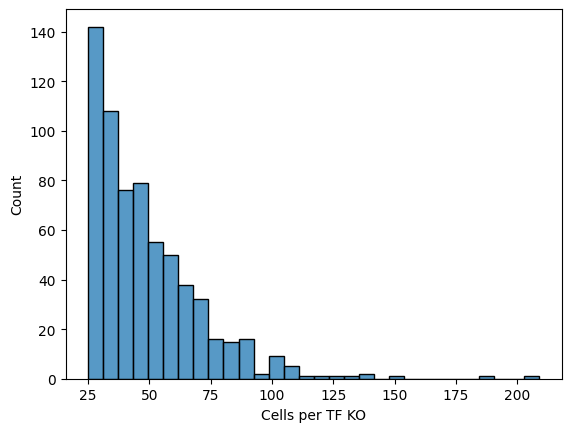

In [ ]:
ax = sns.histplot(cells_per_tf_ko.values, bins=30)
p = plt.xlabel("Cells per TF KO")

In [3]:
def cells_per_batch(adata, dataset_name):
    for run in "ALPHA", "BETA", "GAMMA":
        print(f"In {dataset_name}, run {run} has {adata[adata.obs['run'] == run].shape[0]} cells")

## Filter genes expressed in fewer than 25 cells

Filter out genes that are present in fewer than 25 cells, based on study pipeline

In [4]:
sc.pp.filter_genes(adata_tfs, min_cells=25) # Filter for genes that are present in at least 25 cells
adata_tfs

filtered out 13046 genes that are detected in less than 25 cells


AnnData object with n_obs × n_vars = 31808 × 24521
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [5]:
adata_tfs.write_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_Batch_Normalized.h5ad")

## PCA on cell-by-gene matrix

Use PCA to determine how specific genes contribute to major sources of variation in the cell-by-gene dataset.

In [ ]:
def pca(adata):
    adata = adata.copy()
    sc.pp.scale(adata)
    sc.pp.pca(adata)
    sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
    return adata

computing PCA
    with n_comps=50
    finished (0:00:43)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


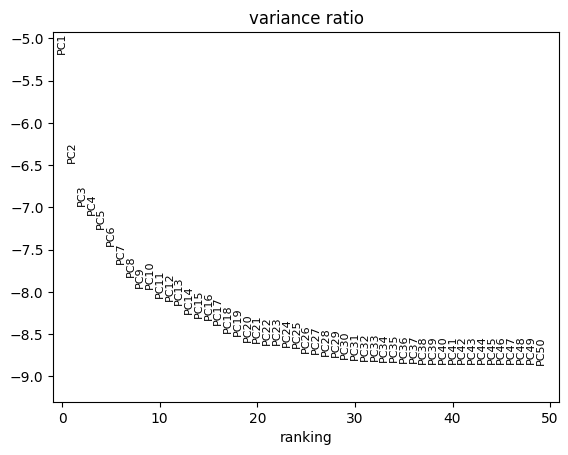

In [ ]:
adata_tfs_pca = pca(adata_tfs)

Get the top 20 genes that contribute to the first 2 PCs. Genes that contribute positively have expression that increases across the PC axis, and genes that contribute negatively have expression that decreases.

In [ ]:
def get_top_pca_genes(adata, top_n):
    genes = adata.var_names
    pc_loadings = adata.varm["PCs"]
    pc1_df = pd.DataFrame({'gene': genes, 'loading': pc_loadings[:, 0]})
    pc2_df = pd.DataFrame({'gene': genes, 'loading': pc_loadings[:, 1]})
    pc1_genes, pc2_genes = list(), list()
    for df, lst in zip((pc1_df, pc2_df), (pc1_genes, pc2_genes)):
        top_pos = df.nlargest(top_n, 'loading')['gene'].tolist()
        lst.append(top_pos)
        top_neg = df.nsmallest(top_n, 'loading')['gene'].tolist()
        lst.append(top_neg)
    return pc1_genes, pc2_genes

In [ ]:
pc1_top_genes, pc2_top_genes = get_top_pca_genes(adata_tfs_pca, 20)
pc1_pos_genes, pc1_neg_genes = pc1_top_genes[0], pc1_top_genes[1]
pc2_pos_genes, pc2_neg_genes = pc2_top_genes[0], pc2_top_genes[1]

In [ ]:
print(f"PC1 top 20 positively contributing genes: {pc1_pos_genes}")
print(f"PC1 top 20 negatively contributing genes: {pc1_neg_genes}")
print(f"PC2 top 20 positively contributing genes: {pc2_pos_genes}")
print(f"PC2 top 20 negatively contributing genes: {pc2_neg_genes}")

PC1 top 20 positively contributing genes: ['RPLP1', 'PTMA', 'RPS14', 'RPS2', 'PRDX1', 'RPL12', 'RPS12', 'RPL8', 'RPS8', 'EEF1A1', 'RPS23', 'RPS27A', 'RPL10', 'RPS18', 'RPL18A', 'RPS28', 'RPL13', 'RPL39', 'RPS3', 'RPL15']
PC1 top 20 negatively contributing genes: ['GRID2', 'PTPRG', 'SNHG14', 'DLGAP1', 'UNC5D', 'ROBO2', 'PRKG1', 'RIMS2', 'XACT', 'GALNT17', 'ROR1', 'CASC15', 'FRAS1', 'GPC6', 'MALAT1', 'CADM2', 'ADGRV1', 'MT-ND6', 'ANK2', 'NLGN1']
PC2 top 20 positively contributing genes: ['MT-ND6', 'MT-ATP8', 'RPS28', 'RPL37A', 'SEMA3E', 'LINC01829', 'C13orf42', 'HDAC2-AS2', 'RPS27', 'GUCY2C-AS1', 'RPS29', 'PTPRG', 'ADGRL3', 'ENSG00000259048', 'RPL37', 'H1-3', 'PVT1', 'FILIP1L', 'ENSG00000286279', 'LINC02997']
PC2 top 20 negatively contributing genes: ['TPT1', 'ACTG1', 'RPS2', 'RPL3', 'NPM1', 'RPL7', 'MARCKSL1', 'GAPDH', 'RPS3A', 'H2AZ1', 'UBE2S', 'PFN1', 'FTH1', 'RPL7A', 'NACA', 'EEF1A1', 'SNRPN', 'HNRNPA1', 'PPP1R14B', 'TUBB2B']


# Feature selection

## HVGs

### Filter genes to 2000 HVGs

With batch correction (OLD)

In [ ]:
# adata_tfs_2000 = adata_tfs.copy()
# sc.pp.highly_variable_genes(adata_tfs_2000, n_top_genes=2000, subset=True, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [ ]:
# adata_tfs_2000

AnnData object with n_obs × n_vars = 31808 × 2000
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
# adata_tfs_2000.write("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad") # Renamed this file to old_tf_kos_by_2000_hvgs.h5ad

Compare 2000 HVGs found with batch-aware HVG selection vs. without. Batch ALPHA has 453 TFs KOs, batch BETA has 8, and batch GAMMA has 1, so HVG selection may need to be performed without a batch key, which differs from the Mali lab pipeline.

In [ ]:
# With batch key
adata_2000_batch = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_2000_batch, n_top_genes=2000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
batch_hvgs = set(adata_2000_batch[:, adata_2000_batch.var["highly_variable"]].var.index)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [ ]:
# Without batch key
adata_2000_no_batch = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_2000_no_batch, n_top_genes=2000, subset=False, flavor='seurat_v3', layer='counts')
no_batch_hvgs = set(adata_2000_no_batch[:, adata_2000_no_batch.var["highly_variable"]].var.index)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [ ]:
print(f"{len(batch_hvgs.intersection(no_batch_hvgs))} HVGs are shared")
print(f"{len(batch_hvgs - no_batch_hvgs)} HVGs are different")

945 HVGs are shared
1055 HVGs are different


5/7/25 HVG selection should be performed without batch correction

In [ ]:
adata_2000 = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_2000, n_top_genes=2000, subset=True, flavor='seurat_v3', layer='counts')
adata_2000

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 31808 × 2000
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_2000.write("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

## DEGS with p-adj < 0.05

Write function to get set of DEGs that pass given LFC threshold and p-adj threshold based on DE results

In [4]:
def filter_degs_lfc(deg_df, lfc_threshold=0.25, padj_threshold=0.05):
    # Get list of perturbations from column labels
    perts = {col.split("_")[0] for col in deg_df.columns}
    # Get genes where |L2FC| > threshold and p-adj < threshold
    lfc_degs = set()
    for pert in perts:
        l2fc_col = f"{pert}_log2FoldChange"
        padj_col = f"{pert}_padj"
        lfc_degs.update(deg_df.loc[(abs(deg_df[l2fc_col]) > lfc_threshold) 
                                   & (deg_df[padj_col] < padj_threshold)].index)
    return lfc_degs

Generate set of DEGs with |LFC| > 0.25

In [5]:
degs_filt_25 = filter_degs_lfc(de_results)
print(len(degs_filt_25))

5095


### Test different LFC thresholds

In [ ]:
def test_n_degs(de_results, padj_thr):
    n_degs_list = list()
    lfc_thr_list = [0, 0.25, 0.5, 0.75, 1, 1.5, 2]
    for lfc_thr in lfc_thr_list:
        n_degs_list.append(len(filter_degs_lfc(de_results, lfc_thr, padj_thr)))
    return lfc_thr_list, n_degs_list

def plot_n_degs(lfc_thr_list, n_degs_list, title, ymax=None):
    ax = sns.lineplot(x=lfc_thr_list, y=n_degs_list, marker="o")
    plt.xlabel("|LFC| Threshold", fontsize=12)
    plt.ylabel("Number of DEGs", fontsize=12)
    if ymax:
        ax.set_ylim(0, ymax)
    plt.title(title, fontsize=14)
    plt.grid()

For p-adj < 0.05

In [16]:
lfc_thresholds, n_degs_0pt05 = test_n_degs(de_results, 0.05)

In [17]:
print(lfc_thresholds)
print(n_degs_0pt05)

[0, 0.25, 0.5, 0.75, 1, 1.5, 2]
[5095, 5095, 5057, 4620, 3606, 1872, 1041]


In [43]:
#plot_n_degs(lfc_thresholds, n_degs_0pt05, "Number of DEGs vs. |LFC| Threshold (p-adj < 0.05)", ymax=5500)

For p-adj < 0.025

In [42]:
lfc_thresholds, n_degs_0pt02 = test_n_degs(de_results, 0.02)
print(n_degs_0pt02)

[3473, 3473, 3434, 3053, 2366, 1290, 765]


For p-adj < 0.01

In [40]:
lfc_thresholds, n_degs_0pt01 = test_n_degs(de_results, 0.01)
print(n_degs_0pt01)

[2780, 2780, 2744, 2427, 1870, 1057, 638]


In [44]:
#plot_n_degs(lfc_thresholds, n_degs_0pt01, "Number of DEGs vs. |LFC| Threshold (p-adj < 0.01)", ymax=3000)

In [45]:
def plot_n_degs_multi_line(x, y1, y2, y3, label1, label2, label3, title, ymax):
    plt.plot(x, y1, label=label1, marker=".", color="tab:red")
    plt.plot(x, y2, label=label2, marker=".", color="tab:green")
    plt.plot(x, y3, label=label3, marker=".", color="tab:blue")
    plt.xlabel("|LFC| Threshold", fontsize=12)
    plt.ylabel("Number of DEGs", fontsize=12)
    if ymax:
        ax.set_ylim(0, ymax)
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

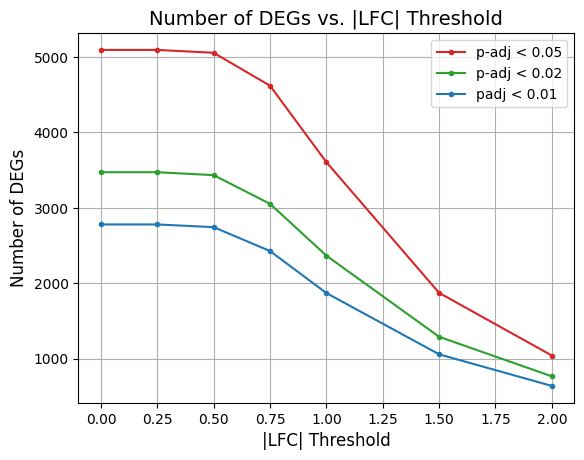

In [46]:
plot_n_degs_multi_line(x=lfc_thresholds, y1=n_degs_0pt05, y2=n_degs_0pt02, y3=n_degs_0pt01,
                       label1="p-adj < 0.05", label2="p-adj < 0.02", label3="padj < 0.01",
                       title="Number of DEGs vs. |LFC| Threshold", ymax=5500)

In [38]:
print(len(filter_degs_lfc(de_results, lfc_threshold=0.95, padj_threshold=0.01)))

2008


### Filter genes to the 5087 DEGs with |LFC| > 0.25 and p-adj < 0.05

Filter genes in TF-KO-by-gene dataset to DEGs with |LFC| > 0.25

In [ ]:
adata_tfs_degs = adata_tfs[:, adata_tfs.var.index.isin(degs_filt_25)].copy()
adata_tfs_degs

AnnData object with n_obs × n_vars = 31808 × 5087
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_degs.write("/home/ranwyl/data_tf_project/tf_kos_by_5087_degs.h5ad")

### Filter genes to union of DEGs and 2000 HVGs

In [6]:
adata_2000 = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_2000, n_top_genes=2000, subset=True, flavor='seurat_v3', layer='counts')
hvgs = adata_2000.var.index.tolist()
print(len(hvgs))
print(hvgs[:5])

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
2000
['ENSG00000290916', 'CFAP74', 'TAS1R1', 'ERRFI1-DT', 'SLC2A5']


In [7]:
hvgs = set(hvgs)
degs = filter_degs_lfc(de_results)
degs_hvgs_union = degs.union(hvgs)
print(len(degs_hvgs_union))

6153


In [9]:
adata_tfs_degs_hvgs = adata_tfs[:, adata_tfs.var.index.isin(degs_hvgs_union)].copy()
adata_tfs_degs_hvgs

AnnData object with n_obs × n_vars = 31808 × 6145
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [10]:
adata_tfs_degs_hvgs.write("/home/ranwyl/data_tf_project/tf_kos_by_6145_degs_hvgs.h5ad")

## DEGs with p-value cutoff

Write function to get set of DEGs that pass given LFC threshold and p-value threshold based on DE results

In [15]:
def filter_degs_lfc_pval(de_df, lfc_threshold=0.25, pval_threshold=0.05, tf_ko_list=None):
    if not tf_ko_list:
        # Get list of perturbations from column labels
        perts = {col.split("_")[0] for col in de_df.columns}
    else:
        perts = tf_ko_list
    # Get genes where |L2FC| > threshold and p-adj < threshold
    deg_set = set()
    for pert in perts:
        l2fc_col = f"{pert}_log2FoldChange"
        pval_col = f"{pert}_pvalue"
        deg_set.update(de_df.loc[(abs(de_df[l2fc_col]) > lfc_threshold) 
                                   & (de_df[pval_col] < pval_threshold)].index)
    return deg_set

### Test number of DEGs with |LFC| > 0.25 and different p-value thresholds

In [25]:
def test_n_degs_pval(de_df, lfc_thr, pval_thr_list):
    tf_kos = {col.split("_")[0] for col in de_df.columns}
    n_degs_list = list()
    for pval_thr in pval_thr_list:
        n_degs_list.append(len(filter_degs_lfc_pval(de_df, lfc_thr, pval_thr, tf_kos)))
    return n_degs_list

def plot_n_degs_pval(pval_thr_list, n_degs_list, title, ymax=None):
    ax = sns.lineplot(x=pval_thr_list, y=n_degs_list, marker="o")
    plt.xlabel("p-value Threshold", fontsize=14)
    plt.ylabel("Number of DEGs", fontsize=14)
    if ymax:
        ax.set_ylim(0, ymax)
    plt.title(title, fontsize=15)
    plt.grid()

In [19]:
pval_thresholds = [0.0005, 0.001, 0.005, 0.01]
n_degs_pval = test_n_degs_pval(de_results, 0.25, pval_thresholds)

In [24]:
print(pval_thresholds)
print(n_degs_pval)

[0.0005, 0.001, 0.005, 0.01]
[5565, 7106, 11006, 12599]


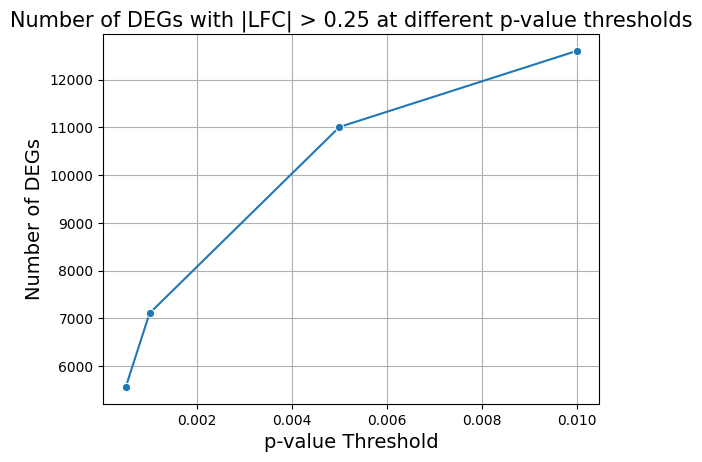

In [26]:
plot_n_degs_pval(pval_thresholds, n_degs_pval, 
                 "Number of DEGs with |LFC| > 0.25 at different p-value thresholds")

### Filter genes to DEGs with |LFC| > 0.25 and p-value < 0.0005

In [28]:
degs_pval = filter_degs_lfc_pval(de_results, pval_threshold=0.0005)
print(len(degs_pval))

5565


In [29]:
adata_tfs_degs_pval = adata_tfs[:, adata_tfs.var.index.isin(degs_pval)].copy()
adata_tfs_degs_pval

AnnData object with n_obs × n_vars = 31808 × 5560
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_degs_pval.write("/home/ranwyl/data_tf_project/tf_kos_by_5560_degs_pval.h5ad")

### Filter genes to union of HVGs and DEGs with |LFC| > 0.25 and p-value < 0.0005

In [ ]:
adata_tfs = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_Batch_Normalized.h5ad")

In [3]:
adata_degs_pval = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5560_degs_pval.h5ad")
degs_pval = adata_degs_pval.var.index.to_list()
print(len(degs_pval))

5560


In [4]:
adata_hvgs = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")
hvgs = adata_hvgs.var.index.tolist()
print(len(hvgs))

2000


In [6]:
degs, hvgs = set(degs_pval), set(hvgs)
deg_hvg_union = degs.union(hvgs)
print(len(deg_hvg_union))

6633


In [7]:
adata_tfs_degs_pval_hvgs = adata_tfs[:, adata_tfs.var.index.isin(deg_hvg_union)].copy()
adata_tfs_degs_pval_hvgs

AnnData object with n_obs × n_vars = 31808 × 6633
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [21]:
adata_tfs_degs_pval_hvgs.X = adata_tfs_degs_pval_hvgs.layers["counts"].copy()

In [22]:
adata_tfs_degs_pval_hvgs.write("/home/ranwyl/data_tf_project/tf_kos_by_6633_degs_pval_hvgs.h5ad")

# Pairwise Pearson correlation matrix of mean profiles

In [9]:
def compute_mean_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    return mean_vector.A1 if hasattr(mean_vector, 'A1') else mean_vector

def tf_create_corrmatrix(adata, v_min=-1, v_max=1, color_map="RdBu"):
    gene_target_groups = adata.obs.groupby('gene_target').indices
    adata_mean_profiles = [compute_mean_profile(adata, indices) for indices in gene_target_groups.values()]
    adata_mean_profiles = np.array(adata_mean_profiles)
    corr_matrix = np.corrcoef(adata_mean_profiles)

    # Plot
    gene_target_labels = list(gene_target_groups.keys())
    distance_dataframe = pd.DataFrame(corr_matrix, index=gene_target_labels, columns=gene_target_labels)
    fig = sns.clustermap(distance_dataframe, cmap=color_map, xticklabels=False, yticklabels=False, vmax=v_max, vmin=v_min, center=0)
    fig.ax_heatmap.set_xlabel('')
    fig.ax_heatmap.set_ylabel('');
    return(distance_dataframe, adata_mean_profiles)

### Pairwise Pearson correlation matrix of mean profiles for 5087-DEG dataset

In [14]:
adata_5087 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5087_degs.h5ad")

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


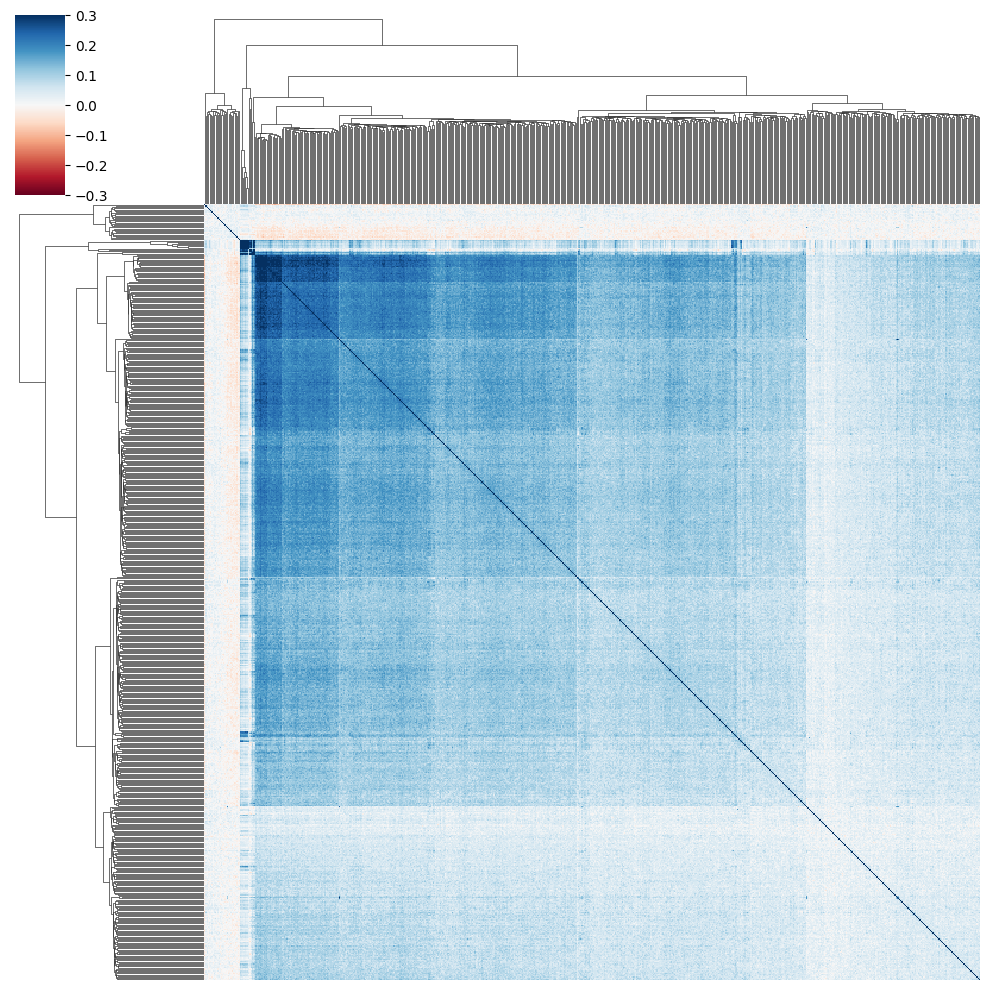

In [15]:
_ = tf_create_corrmatrix(adata_5087, v_min=-0.3, v_max=0.3)

### Pairwise Pearson correlation matrix of mean profiles for 2000-HVG dataset

In [12]:
adata_2000 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

In [101]:
# _ = tf_create_corrmatrix(adata_2000, v_min=-0.3, v_max=0.3)

### Pairwise Pearson correlation matrix of mean profiles, feature set = union of DEGs with p-adj cutoff and HVGs

In [11]:
# adata_degs_hvgs = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_6145_degs_hvgs.h5ad")

In [10]:
# _ = tf_create_corrmatrix(adata_degs_hvgs, v_min=-0.3, v_max=0.3)

### Pairwise Pearson correlation matrix of mean profiles, feature set = union of DEGs with p-val cutoff and HVGs (6633 genes)

In [12]:
adata_degs_hvgs = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_6633_degs_pval_hvgs.h5ad")

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



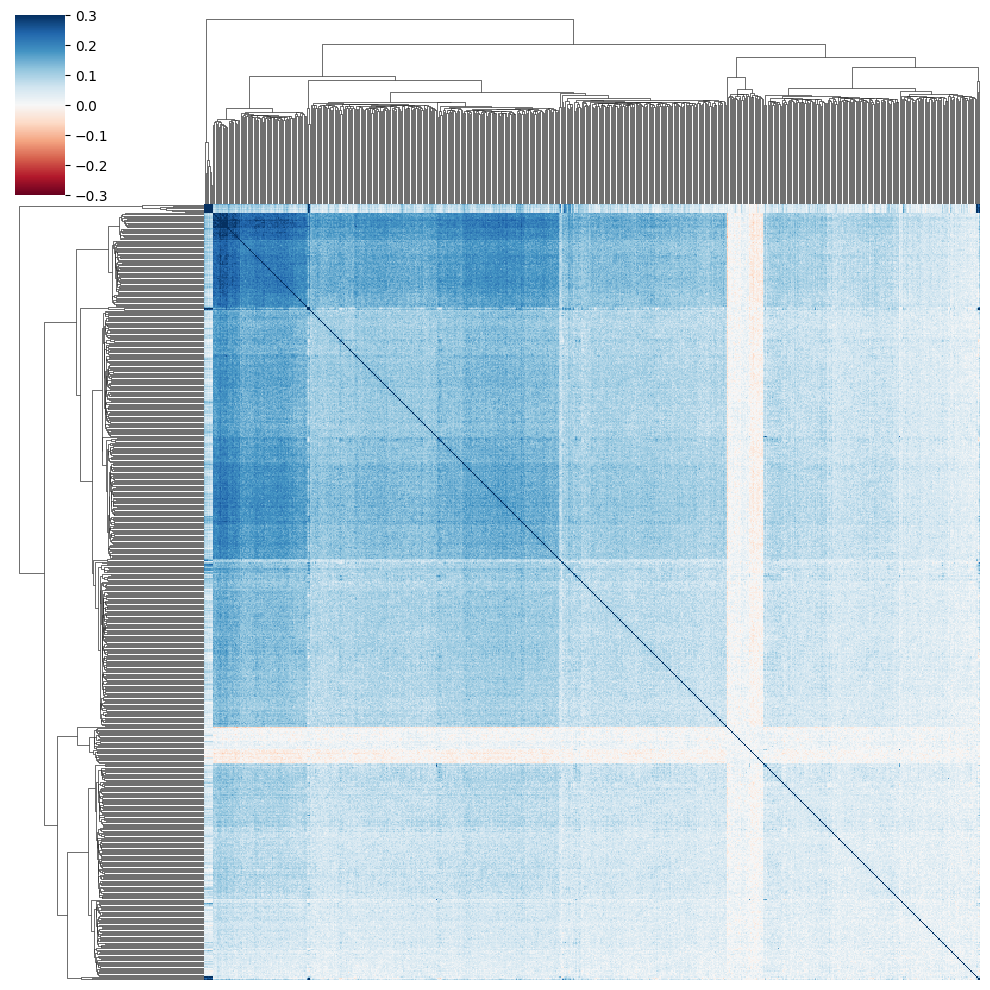

In [23]:
_ = tf_create_corrmatrix(adata_degs_hvgs, v_min=-0.3, v_max=0.3)

# Minimal Distortion Embedding (MDE)

### MDE functions

In [18]:
def compute_mean_normalized_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
    return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

def tf_compute_MDE(adata, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices
    # Changed code to no longer compute mean normalized profiles in parallel -Robin
    mean_profiles = [compute_mean_normalized_profile(adata, indices) for indices in gene_target_groups.values()]
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    pymde.seed(42) # Added by Robin to make pymde.preserve_neighbors() deterministic
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack',
                random_state=42 # Added by Robin to make sklearn.SpectralEmbedding deterministic
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition, 
                                         seed=42 # Added by Robin to make leidenalg.find_partition() deterministic
                                         )
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    cluster_groups = embedding_df.groupby('cluster')
    centroids = cluster_groups[['x', 'y']].mean()
    pairwise_distances = pd.DataFrame(
        squareform(pdist(centroids, metric='euclidean')),
        index=centroids.index,
        columns=centroids.index
    )
    sns.clustermap(pairwise_distances, cmap='PuBuGn')
    plt.title('Pairwise Distance Matrix of Cluster Centroids')
    plt.show()

    # Plot using Plotly with Pastel colormap for discrete clusters
    fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
                     hover_data={'x': True, 'y': True, 'gene_target': True},
                     title='MDE Embedding of Mean Normalized Profiles',
                     color_discrete_sequence=px.colors.qualitative.Bold)
    fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    fig.update_layout(
        showlegend=True,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        plot_bgcolor='white',
        width=1200,  # Increase plot width
        height=1000,  # Increase plot height
        legend_title_text='Cluster',
        coloraxis_showscale=False
    )
    if not label_points: # Added by Robin
        fig.update_traces(text=None)
   
    fig.show()
    
    return adata, embedding, clusters, mean_profiles_array, embedding_df

def gene_targets_per_cluster(embedding_df):
    """
    Return DataFrame where each column contains the perturbations in a cluster.
    """
    cluster_nums = max([int(n) for n in set(embedding_df["cluster"].tolist())])
    cluster_dict = dict()
    for i in range(cluster_nums+1):
        cluster = embedding_df[embedding_df["cluster"] == str(i)]["gene_target"].tolist()
        cluster_dict[i] = cluster
    # Pad all columns to be the same length
    max_n_perts = max(len(cluster_dict[i]) for i in range(len(cluster_dict)))
    cluster_dict = {cluster:(perts + [""]*(max_n_perts-len(perts))) for cluster, perts in cluster_dict.items()}
    perts_in_cluster_df = pd.DataFrame(cluster_dict)
    return perts_in_cluster_df

def plot_n_perts_per_cluster(perts_in_cluster_df, title, ymax=None):
    n_perts_per_cluster = perts_in_cluster_df.nunique().tolist()
    xvals = [i for i in range(len(n_perts_per_cluster))]
    ax = sns.barplot(x=xvals, y=n_perts_per_cluster)
    ax.set_xlabel("Leiden cluster")
    ax.set_ylabel("Number of TF KOs in cluster")
    if ymax:
        ax.set_ylim(0, ymax)
    ax.set_title(title)

### MDE on 5087 DEG dataset

In [2]:
adata_5087 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5087_degs.h5ad")

In [94]:
# mde_5087_8 = tf_compute_MDE(adata_5087, label_points=False, spectral=True, leiden_neighbors=8)

In [33]:
_, _, _, _, embedding_df_5087_8 = mde_5087_8
embedding_df_5087_8.head()

,x,y,gene_target,cluster
0,-3.793770,-2.365308,ADNP2,7
1,0.901927,-6.154710,AEBP1,6
2,3.388259,-1.119113,AHR,9
3,-0.600258,-2.202051,AIRE,0
4,-4.958496,-1.321490,AKAP8,7


In [35]:
perts_in_cluster_5087_8 = gene_targets_per_cluster(embedding_df_5087_8)
perts_in_cluster_5087_8.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,AIRE,AKAP8L,CDX1,ASCL5,BCL6B,ATOH7,AEBP1,ADNP2,ARNT2,AHR,...,ASH1L,DUXA,BACH2,ASCL1,BHLHE40,BHLHE41,CREB5,ASCL2,ASCL3,EBF2
1,ARX,ATMIN,CREB3L3,BARHL1,BSX,GMEB2,ANKZF1,AKAP8,ESRRB,CCDC17,...,CEBPB,FOXE3,CREBL2,FLYWCH1,DEAF1,ETV3L,LHX9,ATF6B,DLX6,KLF1
2,BHLHA9,BHLHE22,CREM,CBX2,DMRT3,GRHL3,ARID2,ARID3B,ETV5,FOXI2,...,HHEX,FOXQ1,DMRTA2,GTF3A,ESRRA,FOXD3,MESP2,CENPX,GATAD2A,NANOG
3,DBX2,CAMTA2,DMBX1,CEBPE,ETV1,HIVEP2,ARNT,BAZ2A,FOXD4L5,FOXM1,...,HNF1A,IRX5,DMRTB1,HMX2,ESRRG,FOXO1,PAX6,DLX4,HES7,NANOGP8
4,ELK1,CEBPA,EHF,EMX1,FIGLA,HLF,BHLHA15,CEBPD,GTF2IRD1,GLIS3,...,IKZF5,ISL1,FOXD4,HOXD13,GATA4,IRF6,RAG1,FOXH1,LIN28B,PITX2


In [95]:
# _ = plot_n_perts_per_cluster(perts_in_cluster_5087_8, "TF KOs per cluster (5087-DEG dataset, 8 Leiden neighbors)")

In [ ]:
perts_in_cluster_5087_8.to_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_5087_degs_8_nbrs.csv")

10 neighbors

In [9]:
# mde_5087_10 = tf_compute_MDE(adata_5087, label_points=False, spectral=True, leiden_neighbors=10)

In [99]:
# _, _, _, _, embedding_df_5087_10 = mde_5087_10
# perts_in_cluster_5087_10 = gene_targets_per_cluster(embedding_df_5087_10)
# _ = plot_n_perts_per_cluster(perts_in_cluster_5087_10, "TF KOs per cluster (5087-DEG dataset, 10 Leiden neighbors)")

### MDE on 2000 HVG dataset

In [7]:
adata_2000 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

In [96]:
# mde_2000_8 = tf_compute_MDE(adata_2000, label_points=False, spectral=True, leiden_neighbors=8)

In [20]:
_, _, _, _, embedding_df_2000_8 = mde_2000_8
perts_in_cluster_2000_8 = gene_targets_per_cluster(embedding_df_2000_8)
perts_in_cluster_2000_8.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,AEBP1,ARID2,ATF6B,CREB5,ARX,CC2D1A,ARHGAP35,AKAP8,BAZ2A,ARNT,...,ATOH1,AIRE,ESX1,AKAP8L,ARID3A,ISL1,ESR1,BHLHA9,KLF4,CAMTA2
1,ATOH7,BCL6B,ESR2,DMRT2,ASCL5,CEBPA,ARNT2,BHLHE40,BHLHE22,CENPS,...,BSX,ARID3B,FOXQ1,CEBPB,CDX1,MEOX2,ETS2,FAM200B,PAX9,NCOA3
2,BACH2,BHLHE41,FOXE3,DMRTB1,BARHL1,CEBPE,BARX1,CBX2,FOSL1,CRX,...,KLF6,DR1,HEY1,FOXO1,NFE2L1,PCGF6,KDM2A,LHX9,TIGD7,PRDM8
3,CREB3L4,DMRT3,FOXJ1,ETV5,BHLHA15,DBX2,CTCFL,CEBPD,FOXD4L5,DLX4,...,LHX5,DRAP1,LEF1,GATAD2B,RFX8,RFX7,RELB,MEIS1,ZBTB26,SP140L
4,CREBL2,EPAS1,FOXS1,FOXK2,CREB3L3,DLX6,DLX2,CENPB,FOXN2,ELK1,...,NFX1,ESRRG,REST,GTF3A,SOX30,SHOX2,TET1,MYPOP,ZNF326,ZNF334


In [21]:
perts_in_cluster_2000_8.to_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_2000_hvgs_8_nbrs.csv")

In [82]:
perts_in_cluster_2000_8 = pd.read_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_2000_hvgs_8_nbrs.csv", header=0, index_col=0)

In [22]:
perts_in_cluster_2000_8.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,AEBP1,ARID2,ATF6B,CREB5,ARX,CC2D1A,ARHGAP35,AKAP8,BAZ2A,ARNT,...,ATOH1,AIRE,ESX1,AKAP8L,ARID3A,ISL1,ESR1,BHLHA9,KLF4,CAMTA2
1,ATOH7,BCL6B,ESR2,DMRT2,ASCL5,CEBPA,ARNT2,BHLHE40,BHLHE22,CENPS,...,BSX,ARID3B,FOXQ1,CEBPB,CDX1,MEOX2,ETS2,FAM200B,PAX9,NCOA3
2,BACH2,BHLHE41,FOXE3,DMRTB1,BARHL1,CEBPE,BARX1,CBX2,FOSL1,CRX,...,KLF6,DR1,HEY1,FOXO1,NFE2L1,PCGF6,KDM2A,LHX9,TIGD7,PRDM8
3,CREB3L4,DMRT3,FOXJ1,ETV5,BHLHA15,DBX2,CTCFL,CEBPD,FOXD4L5,DLX4,...,LHX5,DRAP1,LEF1,GATAD2B,RFX8,RFX7,RELB,MEIS1,ZBTB26,SP140L
4,CREBL2,EPAS1,FOXS1,FOXK2,CREB3L3,DLX6,DLX2,CENPB,FOXN2,ELK1,...,NFX1,ESRRG,REST,GTF3A,SOX30,SHOX2,TET1,MYPOP,ZNF326,ZNF334


In [24]:
n_perts_per_cluster_2000_8 = perts_in_cluster_2000_8.nunique().tolist()
print(n_perts_per_cluster_2000_8)

[49, 48, 46, 39, 38, 36, 35, 34, 33, 32, 31, 30, 28, 26, 23, 22, 18, 14, 14, 14, 13, 12, 12, 10, 10, 10]


In [97]:
# plot_n_perts_per_cluster(perts_in_cluster_2000_8, 
#                          title="TF KOs per cluster (2000-HVG dataset, 8 Leiden neighbors)", ymax=50)

10 Leiden neighbors

In [28]:
# mde_2000_10 = tf_compute_MDE(adata_2000, label_points=False, spectral=True, leiden_neighbors=10)

In [30]:
_, _, _, _, embedding_df_2000_10 = mde_2000_10
perts_in_cluster_2000_10 = gene_targets_per_cluster(embedding_df_2000_10)
perts_in_cluster_2000_10.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,ARID2,AEBP1,ATF6B,ASCL5,BCL6B,CREB5,ARNT,ARHGAP35,AHR,AKAP8,BAZ2A,CC2D1A,ADNP2,ASCL1,BHLHA9,DACH2,AIRE,ATMIN,CSRNP2,ARID3A
1,ARX,ATOH7,FOXE3,ASH1L,BHLHE41,DMRT2,ATOH1,ARNT2,AKAP8L,BHLHE40,BHLHE22,CEBPA,ANKZF1,FLYWCH1,ESR1,DEAF1,ARID3B,CHAMP1,DUXA,CDX1
2,BARHL1,BACH2,FOXJ1,BHLHA15,CAMTA2,DMRTB1,BSX,BARX1,ASCL3,CBX2,FOSL1,CEBPE,ASCL2,HMX2,ETS2,ETS1,CENPS,DNMT1,ERG,NFE2L1
3,CREB3L3,CREB3L4,FOXQ1,DMRTC2,DMRT3,ETV5,ELK1,CTCFL,CEBPB,CEBPD,FOXD4L5,DBX2,CCDC17,HOXD13,FAM200B,FOXH1,CRX,E2F4,ESRRB,NR1I3
4,EPAS1,CREBL2,HEY1,GMEB2,ERF,FOXK2,HES3,DLX2,EBF3,CENPB,FOXN2,DLX6,CENPX,KLF1,KDM2A,HEY2,DLX4,EBF2,HIVEP2,RFX8


In [98]:
# plot_n_perts_per_cluster(perts_in_cluster_2000_10, "TF KOs per cluster (2000-HVG dataset, 10 Leiden neighbors)")

In [31]:
perts_in_cluster_2000_10.to_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_2000_hvgs_10_nbrs.csv")

### MDE with union of DEGS with p-adj cutoff and HVGs as features

In [14]:
# adata_degs_hvgs = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_6145_degs_hvgs.h5ad")

In [15]:
# mde_degs_hvgs_8 = tf_compute_MDE(adata_degs_hvgs, label_points=False, spectral=True, leiden_neighbors=8)

In [17]:
# _, _, _, _, embedding_df_degs_hvgs_8 = mde_degs_hvgs_8
# perts_in_cluster_degs_hvgs_8 = gene_targets_per_cluster(embedding_df_degs_hvgs_8)
# perts_in_cluster_degs_hvgs_8.head()

In [16]:
# plot_n_perts_per_cluster(perts_in_cluster_degs_hvgs_8, 
#                          title="TF KOs per cluster (DEG-HVG union dataset, 8 Leiden neighbors)", ymax=50)

### MDE using union of DEGS with p-value cutoff and HVGs as features

In [25]:
adata_degs_hvgs = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_6633_degs_pval_hvgs.h5ad")

Jun 04 06:11:55 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Jun 04 06:11:55 PM: The following items have duplicates [ 96 107 267 295 438]
Jun 04 06:11:55 PM: Fitting a centered embedding into R^2, for a graph with 652 items and 111527 edges.
Jun 04 06:11:55 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Jun 04 06:11:55 PM: iteration 0000 | distortion 0.390002 | residual norm 0.0579172 | step length 1 | percent change 0.160387
Jun 04 06:11:58 PM: iteration 0100 | distortion 0.096729 | residual norm 5.27028e-05 | step length 1 | percent change 0.205676
Jun 04 06:12:01 PM: iteration 0200 | distortion 0.096027 | residual norm 3.57865e-05 | step length 1 | percent change 0.0655651
Jun 04 06:12:03 PM: iteration 0300 | distortion 0.095797 | residual norm 1.99484e-05 | step length 1 | percent change 0.0399303
Jun 04 06:12:06 PM: iteration 0400 | distortion 0.095431 | residual norm 7.56757e-05 | 

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



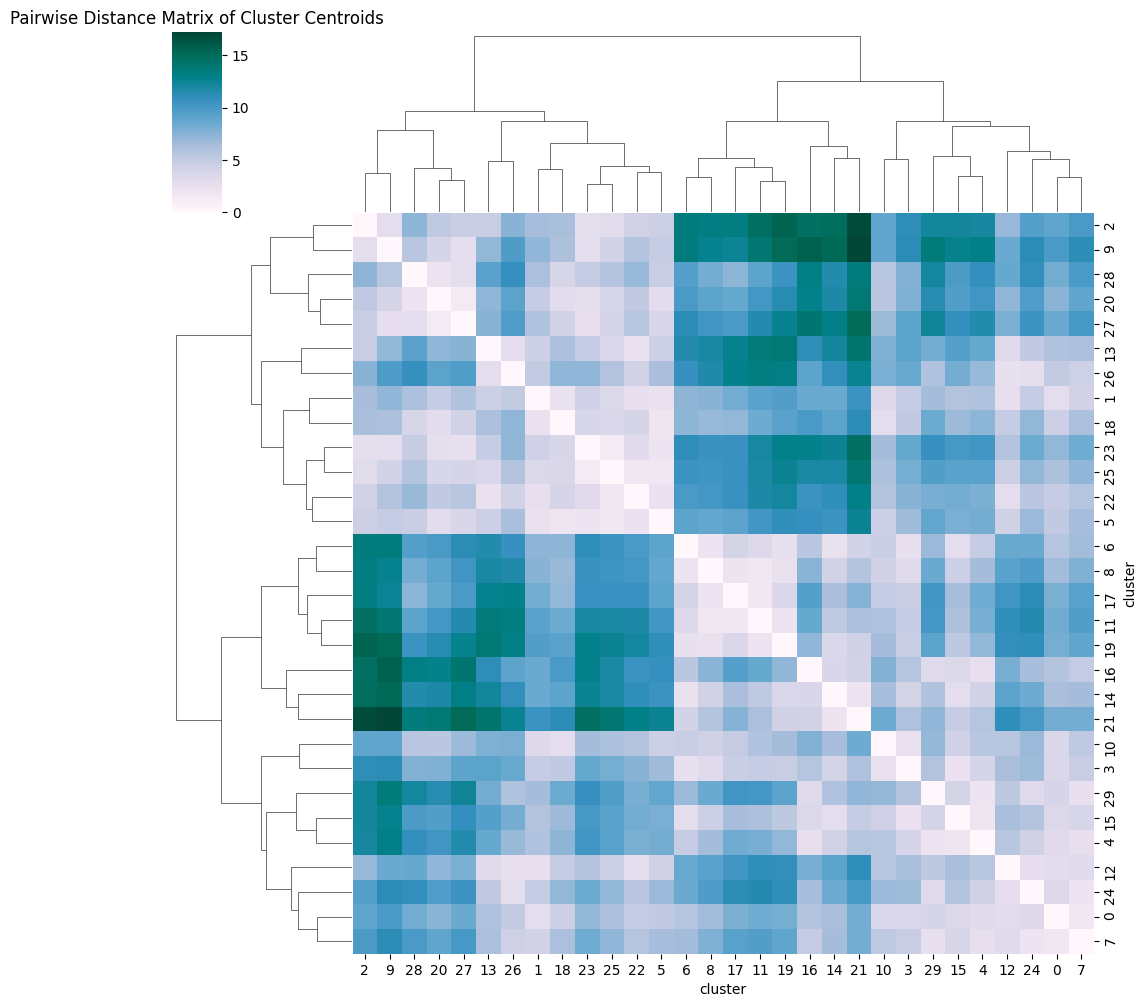

In [26]:
mde_degs_hvgs_8 = tf_compute_MDE(adata_degs_hvgs, label_points=False, spectral=True, leiden_neighbors=8)

## Overrepresentation analysis (ORA)

We seek to functionally annotate each TF KO cluster using overrepresentation analysis (ORA), which is performed on a user-submitted list of DEGs. For any given TF KO cluster, every TF KO in the cluster will have its own DEGs, and we want to generate a set of upregulated genes and a set of downregulated genes that represents the cluster.

Here we will try the following approach for each TF KO cluster. First, read in the full DE results, subset the results for the TF KOs in the cluster, and filter only genes with p-adj < 0.05. Next, for each TF KO, take the top n upregulated genes (i.e. the n genes with the highest LFC). Then take the intersection of the n genes per TF KO.

We will try this with the clusters from the MDE generated using 5087 DEGs as features and 8 nearest neighbors in the neighborhood graph for Leiden clustering.

Read in differential expression analysis results from TF KO and NTC dataset (85% sample fraction, LFC shrinkage performed with adapt=False)

In [2]:
de_results = pd.read_pickle("/home/ranwyl/results_tf_project/TF_KO_NTC_DE_results.pkl")

In [3]:
de_results.head()

,DMRT2_baseMean,DMRT2_log2FoldChange,DMRT2_lfcSE,DMRT2_stat,DMRT2_pvalue,DMRT2_padj,OSR2_baseMean,OSR2_log2FoldChange,OSR2_lfcSE,OSR2_stat,...,ZBED6_lfcSE,ZBED6_stat,ZBED6_pvalue,ZBED6_padj,FAM200B_baseMean,FAM200B_log2FoldChange,FAM200B_lfcSE,FAM200B_stat,FAM200B_pvalue,FAM200B_padj
A1BG,5.197361,0.603388,0.610262,1.249251,0.211573,NaN,3.271476,-0.219247,0.719732,-0.436204,...,0.928560,-1.333630,0.182325,0.93709,3.431164,-0.557770,0.756780,-1.045982,0.295569,0.943485
A1BG-AS1,2.117718,0.544581,0.911720,0.986719,0.323780,NaN,0.659727,-0.021330,1.140542,-0.048274,...,1.246887,-0.863337,0.387952,0.93709,0.627773,-0.762906,1.404104,-1.112549,0.265902,0.943485
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,0.349860,-0.390388,1.225741,-0.692164,0.488835,NaN,0.826464,-0.187075,1.073352,-0.401825,...,1.930966,1.844563,0.065101,0.93709,0.643332,0.025018,1.154267,0.060363,0.951867,0.979964
A2M-AS1,0.311871,0.340470,1.828676,0.582373,0.560315,NaN,0.976668,0.678086,1.342768,1.186024,...,1.135588,-0.197266,0.843620,0.93709,0.823219,0.181208,1.157592,0.401337,0.688172,0.943485


In [4]:
clusters_5087_8 = pd.read_csv("/home/ranwyl/results_tf_project/tf_ko_clusters_5087_degs_8_nbrs.csv", header=0, index_col=0)

In [5]:
clusters = clusters_5087_8

In [21]:
clusters_strong = pd.read_csv("/home/ranwyl/results_tf_project/strong_tf_ko_clust_degs_8nbrs.csv")

In [25]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [27]:
def get_cluster_degs(cluster_df, de_df, cluster_num, n_degs_per_tf_ko, padj_threshold, lfc_threshold):
    """
    Generate a set of DEGs with p-adj < padj_threshold and |LFC| > lfc_threshold 
    for cluster number cluster_num in cluster_df, based on the DE results of de_df.
    """
    # Change cluster number to string
    if type(cluster_num) is not str:
        cluster_num = str(cluster_num)
    # Get TF KOs in cluster column (excluding NaN values)
    cluster_tf_ko_list = cluster_df[cluster_num][cluster_df[cluster_num].notna()].tolist()
    # Filter DE DF to only TF KOs
    de_df_cols = [col for col in de_df.columns if any(f"{tf_ko}_" in col for tf_ko in cluster_tf_ko_list)]
    de_df = de_df[de_df_cols]
    # Get top n upregulated and top n downregulated DEGs per TF KO
    up_degs_sets = list()
    down_degs_sets = list()
    n_degs_padj = list()
    n_degs_lfc = list()
    for tf_ko in cluster_tf_ko_list:
        tf_ko_de_df = de_df.filter(like=f"{tf_ko}_", axis=1)
        # Filter by p-adj and LFC thresholds
        tf_ko_de_df = tf_ko_de_df[tf_ko_de_df[f"{tf_ko}_padj"] < padj_threshold]
        n_degs_padj.append(tf_ko_de_df.shape[0]) # Number of genes that pass p-adj threshold
        tf_ko_de_df = tf_ko_de_df[abs(tf_ko_de_df[f"{tf_ko}_log2FoldChange"]) > lfc_threshold]
        n_degs_lfc.append(tf_ko_de_df.shape[0]) # Number of genes that pass LFC threshold
        # Top upregulated DEGs
        tf_ko_up_deg_df = tf_ko_de_df[tf_ko_de_df[f"{tf_ko}_log2FoldChange"] > 0]
        tf_up_degs = tf_ko_up_deg_df.nlargest(n_degs_per_tf_ko, f"{tf_ko}_log2FoldChange", keep="all").index.tolist()
        up_degs_sets.append(set(tf_up_degs))
        # Top downregulated DEGs
        tf_ko_down_deg_df = tf_ko_de_df[tf_ko_de_df[f"{tf_ko}_log2FoldChange"] < 0]
        tf_down_degs = tf_ko_down_deg_df.nsmallest(n_degs_per_tf_ko, f"{tf_ko}_log2FoldChange", keep="all").index.tolist()
        down_degs_sets.append(set(tf_down_degs))
    # Create DataFrames to display DEG results
    df_results = [n_degs_padj, n_degs_lfc, 
                  [len(s) for s in up_degs_sets], [len(s) for s in down_degs_sets]]
    df_index = ["# genes with padj < 0.05", f"# genes with padj < 0.05 and |LFC| > {lfc_threshold}", "# upregulated DEGs", "# downregulated DEGs"]
    results_df = pd.DataFrame(df_results, columns=cluster_tf_ko_list, index=df_index)
    # Get intersection of all top n DEGs
    up_degs = set.intersection(*up_degs_sets)
    print(f"{len(up_degs)} upregulated DEGs in intersection of all sets")
    down_degs = set.intersection(*down_degs_sets)
    print(f"{len(down_degs)} downregulated DEGs in intersection of all sets")
    return results_df, up_degs_sets, down_degs_sets

In [34]:
def filter_deg_sets(up_degs_sets, down_degs_sets, cutoff):
    up_degs_sets = [s for s in up_degs_sets if len(s) > cutoff]
    down_degs_sets = [s for s in down_degs_sets if len(s) > cutoff]
    # Get intersection of all top n DEGs
    up_degs = set.intersection(*up_degs_sets)
    print(f"{len(up_degs)} upregulated DEGs found")
    down_degs = set.intersection(*down_degs_sets)
    print(f"{len(down_degs)} downregulated DEGs found")

In [30]:
test_df, test_up, test_down = get_cluster_degs(clusters, de_results, cluster_num=0,
                                               n_degs_per_tf_ko=1000, padj_threshold=0.05, lfc_threshold=0.25)

0 upregulated DEGs in intersection of all sets
0 downregulated DEGs in intersection of all sets


In [31]:
display(test_df)

,AIRE,ARX,BHLHA9,DBX2,ELK1,FOSB,FOXN2,GATA1,GATA5,GSC,IRF8,IRX1,JRKL,MLXIP,MSX2,MYCL,ONECUT2,PAX2,POU3F3,RUNX3,SETDB2,SHOX2,STAT5A,TET2,TFEC,THAP6,TIGD7,TP73,ZBTB39,ZFP30,ZFP41,ZNF32,ZNF57,ZNF143,ZNF200,ZNF212,ZNF256,ZNF341,ZNF398,ZNF416,ZNF441,ZNF461,ZNF511,ZNF556,ZNF610,ZNF684,ZNF728,ZNF735,ZNF891,ZSCAN32
# genes with padj < 0.05,50,3,149,43,3,2,33,17,203,63,0,28,1,7,22,0,12,28,129,43,5,206,0,28,0,199,82,8,21,18,127,76,5,7,146,24,79,7,2,0,309,44,63,1,10,163,36,31,0,63
# genes with padj < 0.05 and |LFC| > 0.25,48,2,102,34,3,1,26,17,182,60,0,28,1,6,15,0,10,20,122,32,5,160,0,26,0,153,71,8,17,12,65,67,5,7,116,24,79,6,2,0,290,42,63,1,10,156,36,31,0,62
# upregulated DEGs,17,1,30,9,2,1,4,9,47,19,0,7,0,3,2,0,6,8,30,13,3,48,0,4,0,60,29,3,3,7,28,19,1,3,36,4,20,4,1,0,88,18,20,1,7,29,11,1,0,29
# downregulated DEGs,31,1,72,25,1,0,22,8,135,41,0,21,1,3,13,0,4,12,92,19,2,112,0,22,0,93,42,5,14,5,37,48,4,4,80,20,59,2,1,0,202,24,43,0,3,127,25,30,0,33


In [32]:
test_df2, test_up2, test_down2 = get_cluster_degs(clusters_strong, de_results, cluster_num=0,
                                               n_degs_per_tf_ko=1000, padj_threshold=0.05, lfc_threshold=0.25)

0 upregulated DEGs in intersection of all sets
0 downregulated DEGs in intersection of all sets


In [33]:
display(test_df2)

,CBX2,EPAS1,FOXK1,GATA6,GSC,HES7,KLF6,MEIS3,MEOX2,NKX2-4,NKX6-1,PA2G4,PAX6,RBCK1,REPIN1,REST,TBX1,TIGD7,TMF1,ZFP41,ZNF16,ZNF80,ZNF222,ZNF280C,ZNF354A,ZNF462,ZNF571,ZNF573,ZNF648,ZNF658,ZNF764,ZNF844
# genes with padj < 0.05,112,183,114,33,63,33,118,123,30,246,67,235,56,50,45,139,10,82,20,127,58,71,109,45,60,225,148,60,58,181,22,54
# genes with padj < 0.05 and |LFC| > 0.25,85,147,106,28,60,31,97,62,27,219,59,234,48,34,31,112,9,71,20,65,49,70,87,43,31,188,144,50,49,154,22,50
# upregulated DEGs,22,32,37,14,19,7,32,20,16,99,20,81,10,17,17,42,7,29,5,28,20,18,28,9,8,87,34,16,15,65,2,13
# downregulated DEGs,63,115,69,14,41,24,65,42,11,120,39,153,38,17,14,70,2,42,15,37,29,52,59,34,23,101,110,34,34,89,20,37
